# Train the SSD model

This is an incomplete notebook for training an SSD model. It's dependent on code in https://github.com/amdegroot/ssd.pytorch.

In [1]:
%matplotlib inline

import glob
import xml.etree.ElementTree as ET

import os
import shutil
import time

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageDraw, ImageFont
import cv2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.autograd import Variable

from data import v2, v1, VOCDetection, detection_collate, VOCroot, VOC_CLASSES
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd

In [2]:
ssd_dim = 300
# means = (104, 117, 123)  # only support voc now. TODO: Change to miniplaces mean
means = (0.45834960097,0.44674252445,0.41352266842)
num_classes = 175
batch_size = 16
accum_batch_size = 32

iter_size = accum_batch_size / batch_size
start_iter = 0
max_iter = 120000

transform = SSDAugmentation(ssd_dim, means)  # Change to None to skip data augmentation

lr = 1e-3
weight_decay = 0.0005
stepvalues = (80000, 100000, 120000)
gamma = 0.1
momentum = 0.9

resume = ""

cuda = True
num_workers = 0

In [3]:
def xavier(param):
    init.xavier_uniform(param)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

## Build network and initialize weights

In [4]:
ssd_net = build_ssd('train', ssd_dim, num_classes)

if cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    net = torch.nn.DataParallel(ssd_net).cuda()
    cudnn.benchmark = True
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    net = ssd_net
    

if resume:
    print('Resuming training, loading {}...'.format(resume))
    ssd_net.load_weights(resume)
else:
    # vgg_weights = torch.load(args.save_folder + args.basenet)
    # print('Loading base network...')
    # ssd_net.vgg.load_state_dict(vgg_weights)
    
    print('Initializing weights...')
    # initialize newly added layers' weights with xavier method
    ssd_net.extras.apply(weights_init)
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)    

Initializing weights...


In [5]:
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=momentum, weight_decay=weight_decay)
criterion = MultiBoxLoss(num_classes, 0.5, True, 0, True, 3, 0.5, False, cuda)

## Data loading code

In [6]:
class MiniPlacesDetection(data.Dataset):
    """MiniPlaces object detection object
    
    input is image, target is annotation
    
    Arguments:
        
    """
    
    def __init__(self, root="", mode="train", transform=None, dataset_name='MiniPlaces'):
        self.root = root
        self.transform = transform
        self.name = dataset_name
        self.mode = mode
        self.xml_glob_pattern = os.path.join(self.root, "objects", self.mode, "*/*/*.xml")
        
        self.load_objects()

    def __len__(self):
        return len(self.objects)
    
    def __getitem__(self, index):
        im, target, h, w = self.pull_item(index)
        return im, target

    def pull_image(self, index):
        '''Returns the original image object at index in PIL form

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to show
        Return:
            PIL img
        '''
        obj = self.objects[index]
        path = os.path.join(self.root, obj["path"])
        im = cv2.imread(path, cv2.IMREAD_COLOR)
        if im.shape[1] != ssd_dim or im.shape[2] != ssd_dim:
            im = cv2.resize(im, (ssd_dim, ssd_dim))
        return im

    def pull_item(self, index):
        img = self.pull_image(index)
        height, width, channels = img.shape
        
        obj = self.objects[index]
        target = []
        for i, objectdata in enumerate(obj["objects"]):
            box_and_label = objectdata[:]
            box_and_label[0] /= 128
            box_and_label[1] /= 128
            box_and_label[2] /= 128
            box_and_label[3] /= 128
            target.append(box_and_label)

        if self.transform is not None:
            target = np.array(target)
            
            img, boxes, labels = self.transform(img, target[:, :4], target[:, 4])
            # to rgb
            img = img[:, :, (2, 1, 0)]
            # img = img.transpose(2, 0, 1)
            target = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return torch.from_numpy(img).permute(2, 0, 1).cuda(), target, height, width

    def load_objects(self):
        object_files = glob.glob(self.xml_glob_pattern)
        object_files.sort()
        
        self.objects = list()

        for path in object_files:
            with open(path, "r") as f:
                xml = f.read()
                xml = """<?xml version="1.0"?>
                <base>
                """ + xml + """
                </base>
                """

                tree = ET.fromstring(xml)
                filename = os.path.basename(path).replace(".xml", ".jpg")
                path = os.path.join(self.root, "images", self.mode, tree.find("folder").text[1:], filename)

                objs = []
                for obj in tree.findall("objects"):
                    bndbox = obj.find("bndbox")
                    objdata = [
                        int(bndbox.find("xmin").text),
                        int(bndbox.find("ymin").text),
                        int(bndbox.find("xmax").text),
                        int(bndbox.find("ymax").text),
                        int(obj.find("class").text),
                    ]
                    objs.append(objdata)

                data = {
                    "path": path,
                    "class": int(tree.find("class").text),
                    "objects": objs,
                }
                
                if len(objs):
                    self.objects.append(data)
        print("Num train images:", len(self.objects))
        print("Num bounding boxes:", sum(map(lambda o: len(o['objects']), self.objects)))

Num train images: 3296
Num bounding boxes: 46706


RuntimeError: can't convert CUDA tensor to numpy (it doesn't support GPU arrays). Use .cpu() to move the tensor to host memory first.

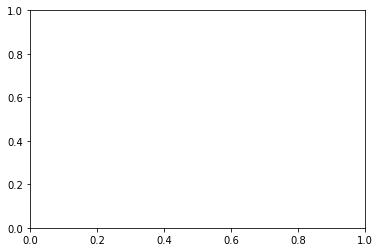

In [7]:
dataset = MiniPlacesDetection(
            root="/workspace/miniplaces/data",
            mode="train",
            transform=None)

img, target, h, w = dataset.pull_item(50)

fig,ax = plt.subplots(1)
ax.imshow((img.permute(1, 2, 0).numpy() + means).astype(np.uint8)[:,:,::-1])

for i in range(len(target)):
    rect = patches.Rectangle(
        (target[i][0] * w, target[i][1] * h),
        target[i][2] * w - target[i][0] * w,
        target[i][3] * h - target[i][1] * h,
        linewidth=2,edgecolor='r',facecolor='none')
    print("Object:", target[i])
    ax.add_patch(rect)

del dataset

## Train the SSD

In [ ]:
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = lr * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
net.cuda()
net.train()
criterion.cuda()

# loss counters
loc_loss = 0  # epoch
conf_loss = 0
epoch = 0

print('Loading Dataset...')
dataset = MiniPlacesDetection(
            root="/workspace/miniplaces/data",
            mode="train",
            transform=None)
print('Training SSD on', dataset.name)

epoch_size = len(dataset) // batch_size
step_index = 0
batch_iterator = None
data_loader = data.DataLoader(dataset, batch_size, num_workers=num_workers,
                              shuffle=True, collate_fn=detection_collate)

In [ ]:
for iteration in range(start_iter, max_iter):
    if (not batch_iterator) or (iteration % epoch_size == 0):
        # create batch iterator
        batch_iterator = iter(data_loader)

    if iteration in stepvalues:
        step_index += 1
        adjust_learning_rate(optimizer, gamma, step_index)
        # reset epoch loss counters
        loc_loss = 0
        conf_loss = 0
        epoch += 1

    # load train data
    images, targets = next(batch_iterator)
    
    if cuda:
        images = images.float() / 255. - 0.5
        images = Variable(images.cuda(async=True))
        targets = [Variable(anno.cuda(async=True), volatile=True) for anno in targets]
    else:
        images = Variable(images.float())
        targets = [Variable(anno, volatile=True) for anno in targets]

    # forward
    t0 = time.time()
    out = net(images)
    out = tuple(out[i].cuda() for i in range(len(out)))

    # backprop
    optimizer.zero_grad()
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    loss.backward()
    optimizer.step()
    t1 = time.time()
    
    # record loss
    loc_loss += loss_l.data[0]
    conf_loss += loss_c.data[0]
    
    # if iteration % 10 == 0:
    print('Timer: %.4f sec.' % (t1 - t0))
    print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data[0]), end=' ')
    
    if iteration % 100 == 0 or iteration == max_iter - 1:
        print('Saving state, iter:', iteration)
        torch.save(ssd_net.state_dict(),
                   'weights/ssd{}_{}_{}.pth'.format(ssd_dim, dataset.name, repr(iteration)))